In [ ]:
import time
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import networkx as nx
import matplotlib.pyplot as plt

# =========================
#  Model
# =========================

class SimpleMLP(nn.Module):
    """Simple MLP for Fashion-MNIST: 784 -> 128 -> 64 -> 10"""
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Flatten input: (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


# =========================
#  Data Partitioning
# =========================

def partition_data(dataset, num_nodes, alpha=0.5, num_classes=10):
    """
    Partition a dataset into non-IID splits across nodes using a Dirichlet distribution
    over class proportions.

    Parameters
    ----------
    dataset : torch.utils.data.Dataset or Subset
    num_nodes : int
    alpha : float
        Dirichlet concentration parameter. Smaller alpha => more skew (more non-IID).
    num_classes : int

    Returns
    -------
    dict: node_id -> Subset(dataset, indices)
    """
    print(f"Partitioning data into {num_nodes} nodes with Dirichlet(alpha={alpha})")

    # Extract labels (works for FashionMNIST & Subset(FashionMNIST))
    if isinstance(dataset, Subset):
        labels_full = np.array(dataset.dataset.targets)
        base_indices = np.array(dataset.indices)
        labels = labels_full[base_indices]
    else:
        labels = np.array(dataset.targets)
        base_indices = np.arange(len(dataset))

    # Group indices by class in the *subset*
    class_indices = []
    for c in range(num_classes):
        cls_idx = base_indices[labels == c]
        class_indices.append(cls_idx)

    # Dirichlet splits
    node_datasets = {i: [] for i in range(num_nodes)}

    for c_idx in class_indices:
        c_idx = np.array(c_idx)
        if len(c_idx) == 0:
            continue

        np.random.shuffle(c_idx)
        proportions = np.random.dirichlet(np.repeat(alpha, num_nodes))
        proportions = (np.cumsum(proportions) * len(c_idx)).astype(int)[:-1]
        splits = np.split(c_idx, proportions)

        for node_id, split in enumerate(splits):
            node_datasets[node_id].extend(split.tolist())

    # Make Subsets
    datasets_dict = {}
    for node_id in range(num_nodes):
        indices_node = node_datasets[node_id]
        np.random.shuffle(indices_node)
        datasets_dict[node_id] = Subset(dataset, indices_node)
        print(f"Node {node_id}: {len(indices_node)} samples")

    return datasets_dict


# =========================
#  Node + Gossip Network
# =========================

class Node:
    """Represents a single node in the gossip network."""
    def __init__(self, node_id, model, dataset, neighbors, device='cpu'):
        self.id = node_id
        self.model = model
        self.device = device
        self.model.to(device)

        self.dataset = dataset
        self.dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        self.neighbors = neighbors

        # Metrics
        self.bytes_sent = 0
        self.bytes_received = 0
        self.train_losses = []
        self.train_accuracies = []

    def local_train(self, epochs=1, lr=0.01):
        """Local training on the node's data."""
        self.model.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=lr)

        epoch_loss = 0.0
        correct = 0
        total = 0

        for _ in range(epochs):
            for batch_data, batch_labels in self.dataloader:
                batch_data, batch_labels = batch_data.to(self.device), batch_labels.to(self.device)

                outputs = self.model(batch_data)
                loss = criterion(outputs, batch_labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += batch_labels.size(0)
                correct += (predicted == batch_labels).sum().item()

        avg_loss = epoch_loss / max(1, (len(self.dataloader) * epochs))
        accuracy = 100 * correct / total if total > 0 else 0.0

        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)

        return avg_loss, accuracy

    def get_model_params(self):
        """Extract model parameters as a flat tensor."""
        params = [p.data.view(-1) for p in self.model.parameters()]
        return torch.cat(params)

    def set_model_params(self, flat_params):
        """Set model parameters from a flat tensor."""
        start = 0
        for param in self.model.parameters():
            numel = param.numel()
            param.data = flat_params[start:start + numel].view_as(param.data).clone()
            start += numel

    def evaluate(self, test_dataset=None):
        """Evaluate model on a given dataset (default: node's own dataset)."""
        self.model.eval()
        criterion = nn.CrossEntropyLoss()

        if test_dataset is None:
            dataloader = self.dataloader
        else:
            dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

        total = 0
        correct = 0
        total_loss = 0.0

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = total_loss / max(1, len(dataloader))
        accuracy = 100 * correct / total if total > 0 else 0.0

        return avg_loss, accuracy


class GossipNetwork:
    """Manages the gossip learning network."""
    def __init__(self, graph, model_template, datasets, device='cpu'):
        self.graph = graph
        self.device = device
        self.nodes = {}

        # Initialize nodes
        for node_id in graph.nodes():
            neighbors = list(graph.neighbors(node_id))
            node_model = type(model_template)()
            node_model.load_state_dict(model_template.state_dict())

            self.nodes[node_id] = Node(
                node_id=node_id,
                model=node_model,
                dataset=datasets[node_id],
                neighbors=neighbors,
                device=device
            )

        self.mixing_matrix = self.compute_mixing_matrix()

        self.total_bytes_sent = 0
        self.round_communication = []

    def compute_mixing_matrix(self):
        """Build Metropolis-Hastings mixing matrix."""
        n = self.graph.number_of_nodes()
        W = np.zeros((n, n))
        degrees = dict(self.graph.degree())

        for i in self.graph.nodes():
            for j in self.graph.neighbors(i):
                W[i, j] = 1.0 / (1 + max(degrees[i], degrees[j]))

        for i in self.graph.nodes():
            # Avoid deprecated np.sum(generator)
            W[i, i] = 1.0 - sum(W[i, j] for j in self.graph.neighbors(i))

        return W

    def gossip_round(self, local_epochs=1, lr=0.01):
        """
        Perform one synchronized gossip round:
        1. Local training on each node
        2. Each node sends its parameters to neighbors
        3. Each node averages received parameters
        """
        # Step 1: local training
        for node in self.nodes.values():
            node.local_train(epochs=local_epochs, lr=lr)

        # Step 2: collect params
        old_params = {node_id: node.get_model_params()
                      for node_id, node in self.nodes.items()}

        round_bytes = 0
        param_size_bytes = next(iter(old_params.values())).numel() * 4  # float32

        # Step 3: gossip averaging
        for i, node in self.nodes.items():
            new_params = torch.zeros_like(old_params[i])

            for j in range(len(self.nodes)):
                weight = self.mixing_matrix[i][j]
                if weight > 0:
                    new_params += weight * old_params[j]

                    # communication accounting
                    if i != j and j in node.neighbors:
                        round_bytes += param_size_bytes
                        node.bytes_received += param_size_bytes
                        self.nodes[j].bytes_sent += param_size_bytes

            node.set_model_params(new_params)

        self.total_bytes_sent += round_bytes
        self.round_communication.append(round_bytes)

        return round_bytes

    def evaluate_all_nodes(self, test_dataset=None):
        """Evaluate all nodes and return statistics."""
        accuracies = []
        losses = []

        for node in self.nodes.values():
            loss, acc = node.evaluate(test_dataset)
            accuracies.append(acc)
            losses.append(loss)

        stats = {
            'mean_accuracy': float(np.mean(accuracies)),
            'std_accuracy': float(np.std(accuracies)),
            'min_accuracy': float(np.min(accuracies)),
            'max_accuracy': float(np.max(accuracies)),
            'all_accuracies': accuracies,
            'mean_loss': float(np.mean(losses)),
        }
        return stats

    def get_node_metrics(self):
        """Compute node-level metrics for each node in the graph."""
        G = self.graph
        degrees = dict(G.degree())
        clustering = nx.clustering(G)
        avg_neighbor_degree = nx.average_neighbor_degree(G)

        node_metrics = {}
        for node in G.nodes():
            node_metrics[node] = {
                "degree": degrees[node],
                "clustering": clustering[node],
                "avg_neighbor_degree": avg_neighbor_degree[node],
            }
        return node_metrics

    def get_graph_metrics(self):
        """Compute and return graph-level metrics."""
        metrics = {
            'num_nodes': self.graph.number_of_nodes(),
            'num_edges': self.graph.number_of_edges(),
            'avg_degree': float(np.mean([d for _, d in self.graph.degree()])),
            'avg_clustering': float(nx.average_clustering(self.graph)),
        }

        if nx.is_connected(self.graph):
            metrics['diameter'] = nx.diameter(self.graph)
            metrics['avg_path_length'] = float(nx.average_shortest_path_length(self.graph))
        else:
            metrics['diameter'] = float('inf')
            metrics['avg_path_length'] = float('inf')

        return metrics


# =========================
#  Training Loop
# =========================

def train_gossip_learning(
    network,
    num_rounds=20,
    local_epochs=1,
    lr=0.01,
    test_dataset=None,
    convergence_threshold=70.0,
    dispersion_threshold=5.0,
):
    """
    Train gossip network for up to num_rounds, but stop early if BOTH:
      - mean_accuracy >= convergence_threshold
      - std_accuracy  <= dispersion_threshold
    are satisfied.
    """
    metrics = {
        'rounds': [],
        'mean_accuracy': [],
        'std_accuracy': [],
        'min_accuracy': [],
        'max_accuracy': [],
        'communication_mb': [],
        'time_per_round': []
    }

    print("Starting Gossip Learning Simulation")
    print(f"Network: {network.graph.number_of_nodes()} nodes, "
          f"{network.graph.number_of_edges()} edges")
    print(f"Parameters: {num_rounds} rounds (max), {local_epochs} local epoch(s), lr={lr}")

    converged = False
    convergence_round = None

    for round_num in range(num_rounds):
        print(f"\n=== Round {round_num + 1}/{num_rounds} ===")

        start_time = time.time()

        # 1) One gossip round (local train + mixing)
        round_bytes = network.gossip_round(local_epochs=local_epochs, lr=lr)

        # 2) Evaluate all nodes
        stats = network.evaluate_all_nodes(test_dataset)

        round_time = time.time() - start_time

        # 3) Log metrics
        metrics['rounds'].append(round_num + 1)
        metrics['mean_accuracy'].append(stats['mean_accuracy'])
        metrics['std_accuracy'].append(stats['std_accuracy'])
        metrics['min_accuracy'].append(stats['min_accuracy'])
        metrics['max_accuracy'].append(stats['max_accuracy'])
        metrics['communication_mb'].append(network.total_bytes_sent / (1024 ** 2))
        metrics['time_per_round'].append(round_time)

        print(f"  Accuracy: {stats['mean_accuracy']:.2f}% ± {stats['std_accuracy']:.2f}% "
              f"[{stats['min_accuracy']:.2f}%, {stats['max_accuracy']:.2f}%]")
        print(f"  Communication: {round_bytes / (1024 ** 2):.3f} MB, "
              f"{network.total_bytes_sent / (1024 ** 2):.3f} MB total")
        print(f"  Time: {round_time:.2f}s\n")

        # 4) Check convergence
        if (
            not converged
            and stats['mean_accuracy'] >= convergence_threshold
            and stats['std_accuracy'] <= dispersion_threshold
        ):
            converged = True
            convergence_round = round_num + 1
            print(f"CONVERGED at round {convergence_round}! "
                  f"Accuracy: {stats['mean_accuracy']:.2f}%\n")

            # EARLY STOP HERE
            break

    print("Training Complete")
    print(f"Final Accuracy: {metrics['mean_accuracy'][-1]:.2f}% ± "
          f"{metrics['std_accuracy'][-1]:.2f}%")
    print(f"Total Communication: {metrics['communication_mb'][-1]:.2f} MB")
    print(f"Total Time: {sum(metrics['time_per_round']):.2f}s")
    if converged:
        print(f"Converged at round: {convergence_round}")
    else:
        print("Did not meet convergence criteria within max rounds.")

    metrics['converged'] = converged
    metrics['convergence_round'] = convergence_round

    return network, metrics



# =========================
#  Matched-degree experiments
# =========================

def run_experiments_matched_degree(
    train_dataset,
    test_dataset,
    num_nodes=12,
    num_rounds=20,
    local_epochs=2,
    lr=0.01,
    alpha=1.0,
    convergence_threshold=70.0,
    dispersion_threshold=5.0,
    seeds=(0, 1, 2),
    k_values=(2, 4, 8),
):
    """
    Run ER/WS/BA experiments where we MATCH the target average degree <k>
    across topologies.

    For each k_target in k_values and each seed:
      - ER:   p = k_target / (n - 1)
      - WS:   k_ws = k_target
      - BA:   m = k_target / 2   (approx, since <k> ~ 2m)

    Returns
    -------
    df_graph : DataFrame
        One row per (topology, seed, k_target) with graph-level metrics.
    df_nodes : DataFrame
        One row per node per experiment with node-level metrics and accuracy.
    """
    print("Partitioning data ONCE for all experiments (non-IID Dirichlet)")
    node_datasets = partition_data(train_dataset, num_nodes, alpha=alpha)

    graph_rows = []
    node_rows = []

    for k_target in k_values:
        print(f"\n===== Target average degree <k> = {k_target} =====")

        for topology in ["ER", "WS", "BA"]:
            for seed in seeds:
                print(f"\n=== Running {topology} (seed={seed}, k_target={k_target}) ===")

                torch.manual_seed(seed)
                np.random.seed(seed)

                # --- Build graph with matched average degree ---
                if topology == "ER":
                    # For G(n,p), E[deg] ≈ p * (n - 1)
                    p = k_target / (num_nodes - 1)
                    graph = nx.erdos_renyi_graph(n=num_nodes, p=p)
                    topo_params = {"p": p, "k_ws": np.nan, "m": np.nan}

                elif topology == "WS":
                    # k_ws must be even and < n; our k_values are 2,4,6,8,10
                    k_ws = int(k_target)
                    p_rewire = 0.3
                    graph = nx.watts_strogatz_graph(n=num_nodes, k=k_ws, p=p_rewire)
                    topo_params = {"p": p_rewire, "k_ws": k_ws, "m": np.nan}

                elif topology == "BA":
                    # <degree> ≈ 2m  =>  m ≈ k_target / 2
                    m = max(1, min(num_nodes - 1, int(round(k_target / 2))))
                    graph = nx.barabasi_albert_graph(n=num_nodes, m=m)
                    topo_params = {"p": np.nan, "k_ws": np.nan, "m": m}

                else:
                    continue

                model_template = SimpleMLP()
                network = GossipNetwork(graph, model_template, node_datasets)

                graph_metrics = network.get_graph_metrics()

                _, metrics = train_gossip_learning(
                    network=network,
                    num_rounds=num_rounds,
                    local_epochs=local_epochs,
                    lr=lr,
                    test_dataset=test_dataset,
                    convergence_threshold=convergence_threshold,
                    dispersion_threshold=dispersion_threshold,
                )

                final_stats = network.evaluate_all_nodes(test_dataset)
                node_metrics = network.get_node_metrics()

                # Graph-level row
                graph_rows.append({
                    "topology": topology,
                    "seed": seed,
                    "k_target": k_target,
                    **topo_params,
                    **graph_metrics,
                    "converged": metrics["converged"],
                    "convergence_round": metrics["convergence_round"],
                    "final_mean_accuracy": metrics["mean_accuracy"][-1],
                    "final_std_accuracy": metrics["std_accuracy"][-1],
                })

                # Node-level rows
                for node_id in range(num_nodes):
                    nm = node_metrics[node_id]
                    acc = final_stats["all_accuracies"][node_id]
                    node_rows.append({
                        "topology": topology,
                        "seed": seed,
                        "k_target": k_target,
                        "node_id": node_id,
                        "degree": nm["degree"],
                        "clustering": nm["clustering"],
                        "avg_neighbor_degree": nm["avg_neighbor_degree"],
                        "final_accuracy": acc,
                        "delta_from_mean": acc - final_stats["mean_accuracy"],
                    })

    df_graph = pd.DataFrame(graph_rows)
    df_nodes = pd.DataFrame(node_rows)

    print("\n=== Graph-level summary (head) ===")
    print(df_graph.head())
    print("\n=== Node-level summary (head) ===")
    print(df_nodes.head())

    return df_graph, df_nodes


# =========================
#  Main
# =========================

if __name__ == "__main__":
    NUM_NODES = 12
    NUM_ROUNDS = 20
    LOCAL_EPOCHS = 2
    LEARNING_RATE = 0.01
    ALPHA = 1.0
    SEEDS = (0, 1, 2)
    K_VALUES = (2, 4, 8)

    torch.manual_seed(42)
    np.random.seed(42)

    print("LOADING FASHION-MNIST DATASET")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset_full = datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    print(f"Total training samples (full): {len(train_dataset_full)}")
    print(f"Total test samples: {len(test_dataset)}")
    train_dataset = train_dataset_full
    print(f"Using FULL training dataset: {len(train_dataset)} samples")

    df_graph, df_nodes = run_experiments_matched_degree(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        num_nodes=NUM_NODES,
        num_rounds=NUM_ROUNDS,
        local_epochs=LOCAL_EPOCHS,
        lr=LEARNING_RATE,
        alpha=ALPHA,
        convergence_threshold=70.0,
        dispersion_threshold=5.0,
        seeds=SEEDS,
        k_values=K_VALUES,
    )

    df_graph.to_csv("gossip_graph_matched_degree.csv", index=False)
    df_nodes.to_csv("gossip_node_matched_degree.csv", index=False)
    print("Saved gossip_graph_matched_degree.csv and gossip_node_matched_degree.csv")


LOADING FASHION-MNIST DATASET
Total training samples (full): 60000
Total test samples: 10000
Using FULL training dataset: 60000 samples
Partitioning data ONCE for all experiments (non-IID Dirichlet)
Partitioning data into 12 nodes with Dirichlet(alpha=1.0)
Node 0: 3302 samples
Node 1: 5918 samples
Node 2: 7115 samples
Node 3: 4251 samples
Node 4: 5615 samples
Node 5: 4738 samples
Node 6: 5426 samples
Node 7: 4165 samples
Node 8: 2575 samples
Node 9: 5518 samples
Node 10: 7057 samples
Node 11: 4320 samples

===== Target average degree <k> = 2 =====

=== Running ER (seed=0, k_target=2) ===
Starting Gossip Learning Simulation
Network: 12 nodes, 7 edges
Parameters: 20 rounds (max), 2 local epoch(s), lr=0.01

=== Round 1/20 ===
  Accuracy: 25.47% ± 6.87% [13.89%, 41.12%]
  Communication: 5.842 MB, 5.842 MB total
  Time: 55.40s


=== Round 2/20 ===
  Accuracy: 32.19% ± 7.30% [19.65%, 47.49%]
  Communication: 5.842 MB, 11.684 MB total
  Time: 54.53s


=== Round 3/20 ===
  Accuracy: 40.33% ± 6

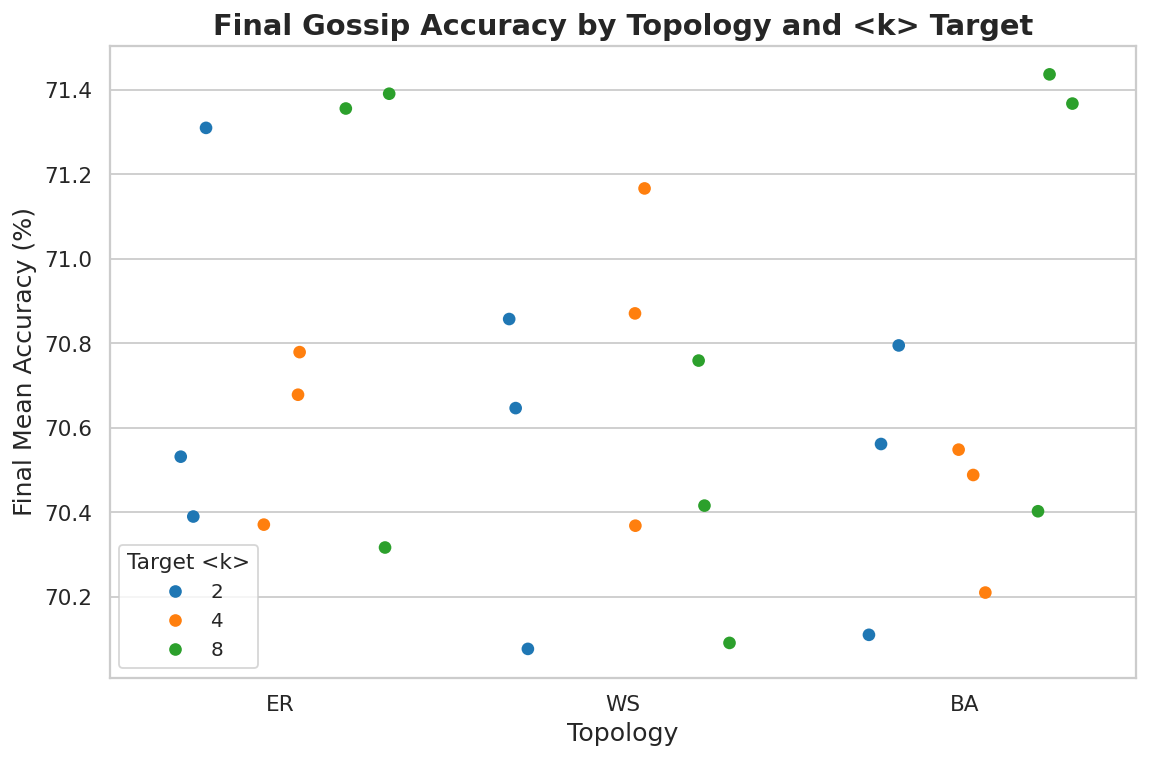

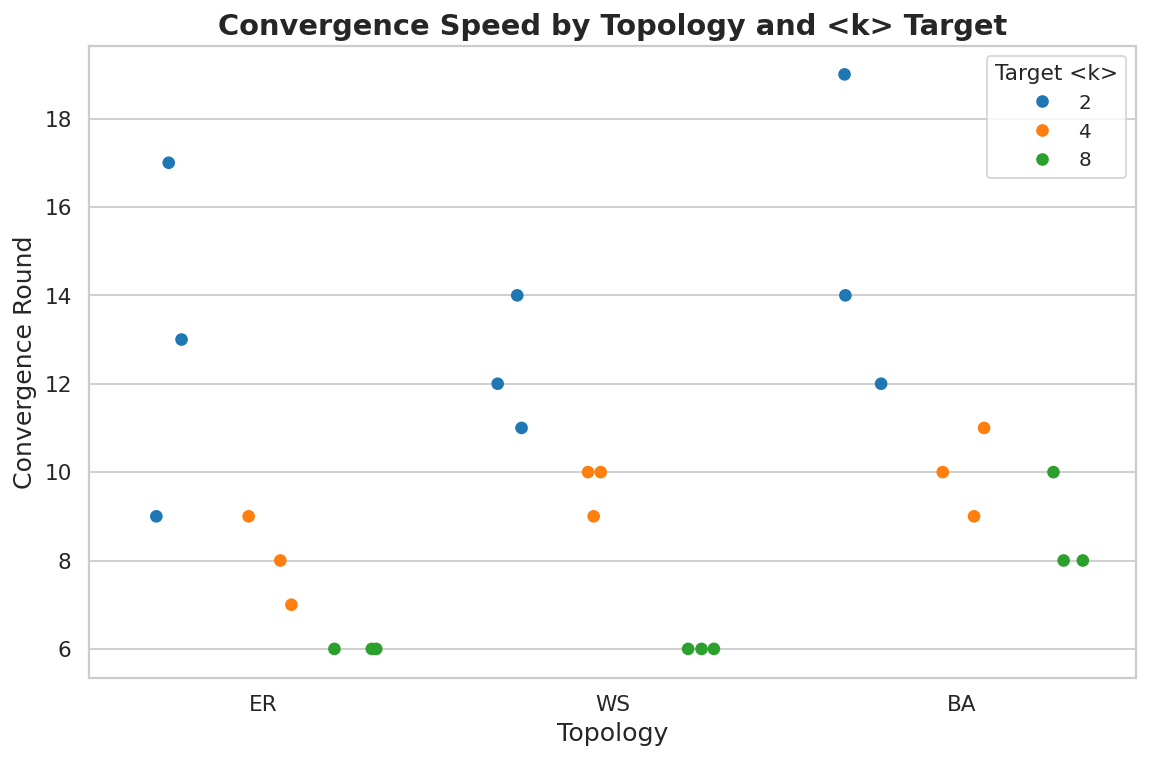

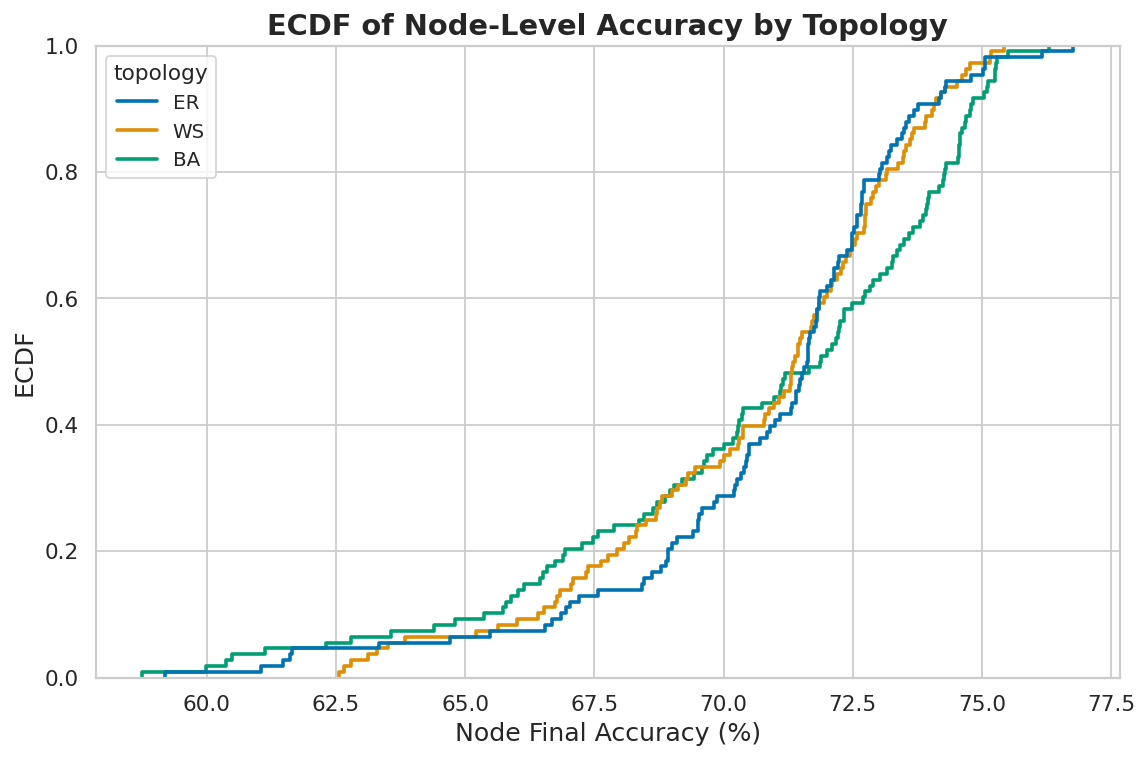

/usr/local/lib/python3.12/dist-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


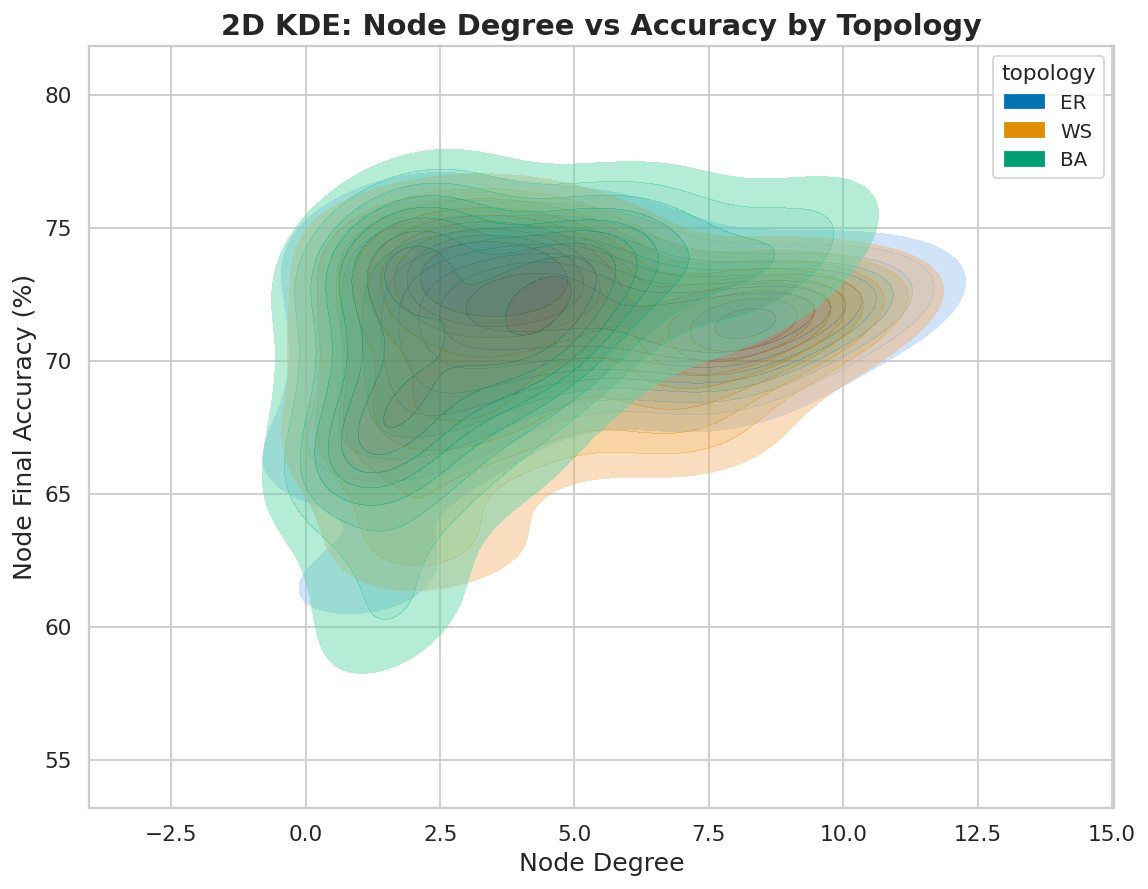

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load results
df_graph = pd.read_csv("gossip_graph_matched_degree.csv")
df_nodes = pd.read_csv("gossip_node_matched_degree.csv")

# Global style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.dpi'] = 130
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['axes.titlesize'] = 16

# Color-blind friendly palettes
topology_palette = sns.color_palette("colorblind", 3)  # ER, WS, BA
k_palette = sns.color_palette("tab10", df_graph["k_target"].nunique())  # BEST for k_target

# =============================
# (A) Stripplot: Final Mean Accuracy
# =============================
plt.figure(figsize=(9, 6))
sns.stripplot(
    data=df_graph,
    x="topology",
    y="final_mean_accuracy",
    hue="k_target",
    dodge=True,
    jitter=0.25,
    size=7,
    palette=k_palette   # UPDATED
)
plt.xlabel("Topology")
plt.ylabel("Final Mean Accuracy (%)")
plt.title("Final Gossip Accuracy by Topology and <k> Target", weight="bold")
plt.legend(title="Target <k>")
plt.tight_layout()
plt.show()

# =============================
# (B) Stripplot: Convergence Round
# =============================
plt.figure(figsize=(9, 6))
sns.stripplot(
    data=df_graph,
    x="topology",
    y="convergence_round",
    hue="k_target",
    dodge=True,
    jitter=0.25,
    size=7,
    palette=k_palette   # UPDATED
)
plt.xlabel("Topology")
plt.ylabel("Convergence Round")
plt.title("Convergence Speed by Topology and <k> Target", weight="bold")
plt.legend(title="Target <k>")
plt.tight_layout()
plt.show()


# =============================
# (C) ECDF plot: Node Accuracy Distribution
# =============================
plt.figure(figsize=(9, 6))
sns.ecdfplot(
    data=df_nodes,
    x="final_accuracy",
    hue="topology",
    palette=topology_palette,
    linewidth=2
)
plt.xlabel("Node Final Accuracy (%)")
plt.ylabel("ECDF")
plt.title("ECDF of Node-Level Accuracy by Topology", weight="bold")
plt.tight_layout()
plt.show()

# =============================
# (D) KDE (bivariate): Degree vs Accuracy
# =============================
plt.figure(figsize=(9, 7))
sns.kdeplot(
    data=df_nodes,
    x="degree",
    y="final_accuracy",
    hue="topology",
    palette=topology_palette,
    fill=True,
    alpha=0.45,
    thresh=0.1,
    linewidth=1.5
)
plt.xlabel("Node Degree")
plt.ylabel("Node Final Accuracy (%)")
plt.title("2D KDE: Node Degree vs Accuracy by Topology", weight="bold")
plt.tight_layout()
plt.show()



Matching experiment parameters: NUM_NODES=12, K_VALUES=(2, 4, 8)
Output directory: /content/results

===== Target average degree <k> = 2 =====
Saved: /content/results/topology_erdos_renyi_k2.pdf
  Erdos-Renyi: 5 edges, avg degree = 0.83, clustering = 0.000


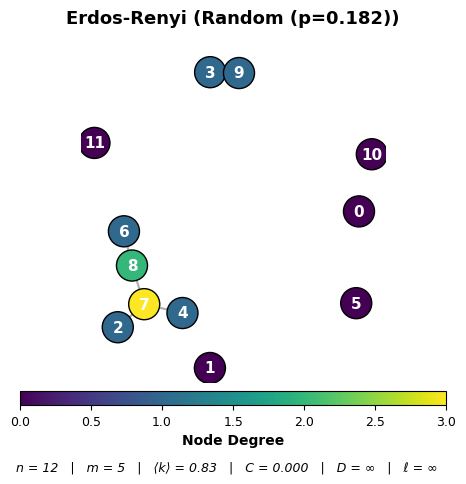

Saved: /content/results/topology_watts_strogatz_k2.pdf
  Watts-Strogatz: 12 edges, avg degree = 2.00, clustering = 0.000


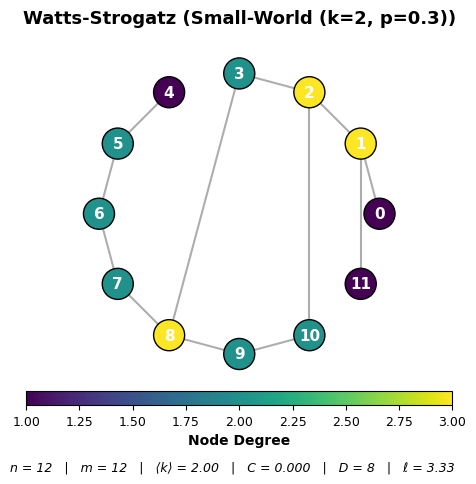

Saved: /content/results/topology_barabasi_albert_k2.pdf
  Barabasi-Albert: 11 edges, avg degree = 1.83, clustering = 0.000


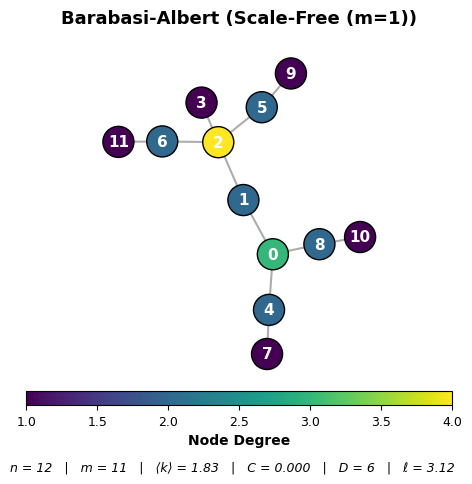


===== Target average degree <k> = 4 =====
Saved: /content/results/topology_erdos_renyi_k4.pdf
  Erdos-Renyi: 16 edges, avg degree = 2.67, clustering = 0.139


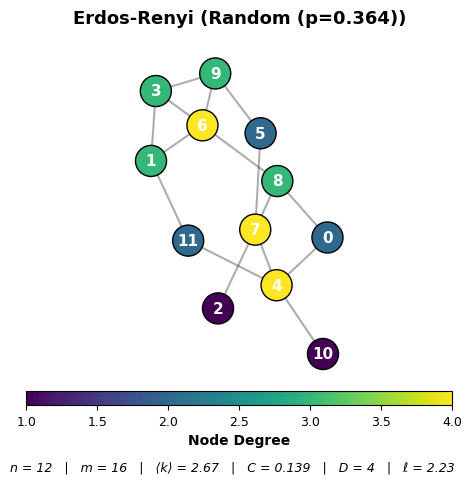

Saved: /content/results/topology_watts_strogatz_k4.pdf
  Watts-Strogatz: 24 edges, avg degree = 4.00, clustering = 0.489


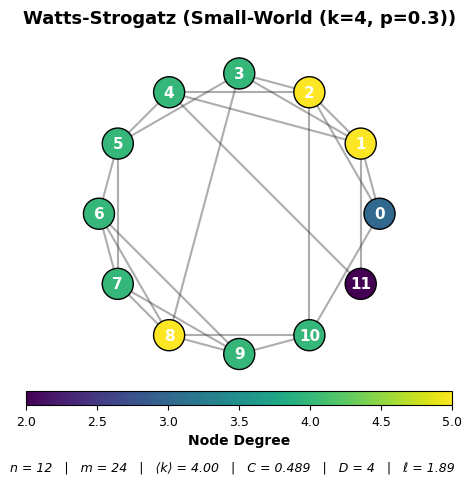

Saved: /content/results/topology_barabasi_albert_k4.pdf
  Barabasi-Albert: 20 edges, avg degree = 3.33, clustering = 0.479


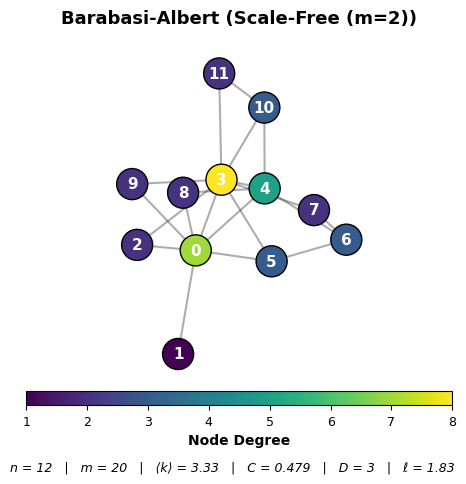


===== Target average degree <k> = 8 =====
Saved: /content/results/topology_erdos_renyi_k8.pdf
  Erdos-Renyi: 43 edges, avg degree = 7.17, clustering = 0.625


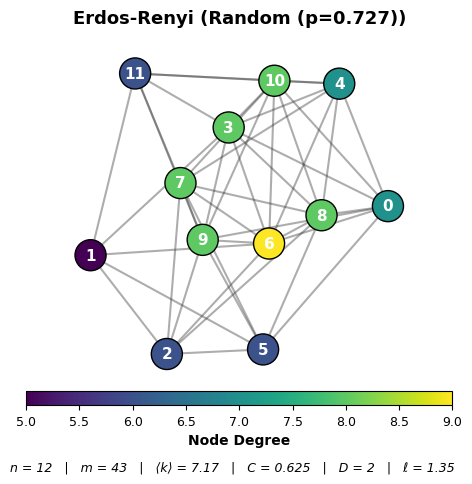

Saved: /content/results/topology_watts_strogatz_k8.pdf
  Watts-Strogatz: 48 edges, avg degree = 8.00, clustering = 0.688


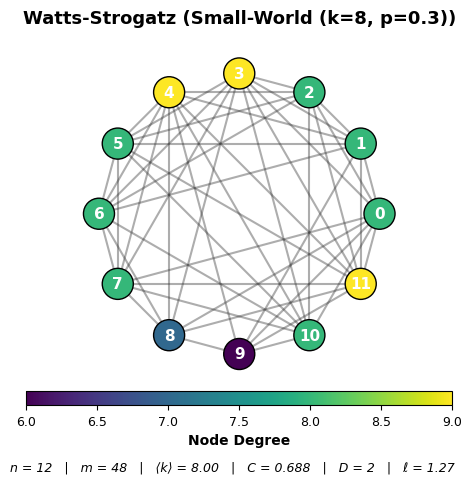

Saved: /content/results/topology_barabasi_albert_k8.pdf
  Barabasi-Albert: 32 edges, avg degree = 5.33, clustering = 0.567


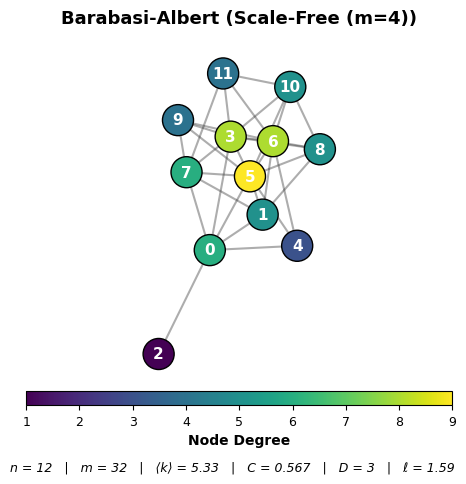


All topology visualizations saved as PDFs

Degree Distributions:
------------------------------------------------------------

Erdos-Renyi (k_target=4):
  Min degree: 1
  Max degree: 4
  Mean degree: 2.67
  Std degree: 1.03
  Degree sequence: [4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 1, 1]

Watts-Strogatz (k_target=4):
  Min degree: 2
  Max degree: 5
  Mean degree: 4.00
  Std degree: 0.82
  Degree sequence: [5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 2]

Barabasi-Albert (k_target=4):
  Min degree: 1
  Max degree: 8
  Mean degree: 3.33
  Std degree: 2.09
  Degree sequence: [8, 7, 5, 3, 3, 3, 2, 2, 2, 2, 2, 1]

Files:

For k_target = 2:
  - results/topology_erdos_renyi_k2.pdf
  - results/topology_watts_strogatz_k2.pdf
  - results/topology_barabasi_albert_k2.pdf

For k_target = 4:
  - results/topology_erdos_renyi_k4.pdf
  - results/topology_watts_strogatz_k4.pdf
  - results/topology_barabasi_albert_k4.pdf

For k_target = 8:
  - results/topology_erdos_renyi_k8.pdf
  - results/topology_watts_strogatz_k8.pdf
  

In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

try:
    from IPython.display import display, Image
    IN_NOTEBOOK = True
except ImportError:
    IN_NOTEBOOK = False

try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
    PROJECT_ROOT = os.path.dirname(SCRIPT_DIR)
except NameError:
    PROJECT_ROOT = os.getcwd()

RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')

os.makedirs(RESULTS_DIR, exist_ok=True)

NUM_NODES = 12
K_VALUES = (2, 4, 8)
SEED = 0

FIG_WIDTH = 5.5
FIG_HEIGHT = 5.0

print(f"Matching experiment parameters: NUM_NODES={NUM_NODES}, K_VALUES={K_VALUES}")
print(f"Output directory: {RESULTS_DIR}")
print("=" * 60)

for k_target in K_VALUES:
    print(f"\n===== Target average degree <k> = {k_target} =====")
    p_er = k_target / (NUM_NODES - 1)
    er_graph = nx.erdos_renyi_graph(n=NUM_NODES, p=p_er, seed=SEED)

    k_ws = int(k_target)
    p_rewire = 0.3
    ws_graph = nx.watts_strogatz_graph(n=NUM_NODES, k=k_ws, p=p_rewire, seed=SEED)

    m_ba = max(1, min(NUM_NODES - 1, int(round(k_target / 2))))
    ba_graph = nx.barabasi_albert_graph(n=NUM_NODES, m=m_ba, seed=SEED)

    topologies = {
        'ER': {
            'graph': er_graph,
            'name': 'Erdos-Renyi',
            'subtitle': f'Random (p={p_er:.3f})',
            'layout': 'spring',
            'filename': os.path.join(RESULTS_DIR, f'topology_erdos_renyi_k{k_target}.pdf')
        },
        'WS': {
            'graph': ws_graph,
            'name': 'Watts-Strogatz',
            'subtitle': f'Small-World (k={k_ws}, p={p_rewire})',
            'layout': 'circular',
            'filename': os.path.join(RESULTS_DIR, f'topology_watts_strogatz_k{k_target}.pdf')
        },
        'BA': {
            'graph': ba_graph,
            'name': 'Barabasi-Albert',
            'subtitle': f'Scale-Free (m={m_ba})',
            'layout': 'spring',
            'filename': os.path.join(RESULTS_DIR, f'topology_barabasi_albert_k{k_target}.pdf')
        }
    }

    for key, topo in topologies.items():
        graph = topo['graph']

        fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

        num_edges = graph.number_of_edges()
        avg_degree = np.mean([d for _, d in graph.degree()])
        avg_clustering = nx.average_clustering(graph)

        if nx.is_connected(graph):
            diameter = nx.diameter(graph)
            avg_path_length = nx.average_shortest_path_length(graph)
        else:
            diameter = float('inf')
            avg_path_length = float('inf')

        if topo['layout'] == 'circular':
            pos = nx.circular_layout(graph)
        else:
            pos = nx.spring_layout(graph, k=0.5, iterations=50, seed=SEED)

        node_degrees = dict(graph.degree())
        node_colors = [node_degrees[node] for node in graph.nodes()]

        nodes = nx.draw_networkx_nodes(graph, pos, ax=ax,
                                        node_color=node_colors,
                                        node_size=500,
                                        cmap='viridis',
                                        vmin=min(node_colors) if node_colors else 0,
                                        vmax=max(node_colors) if node_colors else 1,
                                        edgecolors='black',
                                        linewidths=1.0)

        nx.draw_networkx_edges(graph, pos, ax=ax,
                              alpha=0.4,
                              width=1.5,
                              edge_color='#333333')

        nx.draw_networkx_labels(graph, pos, ax=ax,
                               font_size=11,
                               font_weight='bold',
                               font_color='white',
                               font_family='sans-serif')

        title = f"{topo['name']} ({topo['subtitle']})"
        ax.set_title(title, fontsize=13, fontweight='bold', pad=15)

        ax.axis('off')
        ax.set_aspect('equal')

        cbar = plt.colorbar(nodes, ax=ax, orientation='horizontal',
                            fraction=0.05, pad=0.02, aspect=30)
        cbar.set_label('Node Degree', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)

        path_len_str = f"{avg_path_length:.2f}" if avg_path_length != float('inf') else "∞"
        diam_str = str(diameter) if diameter != float('inf') else "∞"

        metrics_text = (
            f"n = {NUM_NODES}   |   "
            f"m = {num_edges}   |   "
            f"⟨k⟩ = {avg_degree:.2f}   |   "
            f"C = {avg_clustering:.3f}   |   "
            f"D = {diam_str}   |   "
            f"ℓ = {path_len_str}"
        )

        fig.text(0.5, 0.02, metrics_text,
                 fontsize=9,
                 ha='center',
                 va='bottom',
                 family='sans-serif',
                 style='italic')

        plt.subplots_adjust(bottom=0.15)

        filename = topo['filename']
        plt.savefig(filename, format='pdf', bbox_inches='tight',
                    dpi=300, pad_inches=0.05)

        print(f"Saved: {filename}")
        print(f"  {topo['name']}: {num_edges} edges, "
              f"avg degree = {avg_degree:.2f}, "
              f"clustering = {avg_clustering:.3f}")

        if IN_NOTEBOOK:
            plt.show()

        plt.close()

print("\n" + "=" * 60)
print("All topology visualizations saved as PDFs")
print("\nDegree Distributions:")
print("-" * 60)

k_target = 4
p_er = k_target / (NUM_NODES - 1)
er_graph = nx.erdos_renyi_graph(n=NUM_NODES, p=p_er, seed=SEED)
ws_graph = nx.watts_strogatz_graph(n=NUM_NODES, k=k_target, p=0.3, seed=SEED)
m_ba = max(1, int(round(k_target / 2)))
ba_graph = nx.barabasi_albert_graph(n=NUM_NODES, m=m_ba, seed=SEED)

for name, graph in [("Erdos-Renyi", er_graph), ("Watts-Strogatz", ws_graph), ("Barabasi-Albert", ba_graph)]:
    degrees = [d for _, d in graph.degree()]
    print(f"\n{name} (k_target=4):")
    print(f"  Min degree: {min(degrees)}")
    print(f"  Max degree: {max(degrees)}")
    print(f"  Mean degree: {np.mean(degrees):.2f}")
    print(f"  Std degree: {np.std(degrees):.2f}")
    print(f"  Degree sequence: {sorted(degrees, reverse=True)}")

print("\n" + "=" * 60)
print("Files:")
for k in K_VALUES:
    print(f"\nFor k_target = {k}:")
    print(f"  - results/topology_erdos_renyi_k{k}.pdf")
    print(f"  - results/topology_watts_strogatz_k{k}.pdf")
    print(f"  - results/topology_barabasi_albert_k{k}.pdf")
print(f"\nNote: Topologies generated with seed={SEED}, matching experimental runs")